In [2]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [3]:
from matplotlib.pyplot import imread
from ffht import fht
from numpy.lib.scimath import sqrt as csqrt

In [4]:
seed(42)
n = 300
d = n
x = rand(d)
A = rand(n, d)
b = np.abs(A.dot(x))

In [5]:
def f(w, x, nu):
    return np.abs(w - b).sum() + 1/(2*nu)*norm(A.dot(x) - w)**2

def grad_g(w, nu):
    x_star = lstsq(A, w, rcond=None)[0]
    return 1/nu*(w - A.dot(x_star))

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val_x" : [], "func_val_w" : []}
    w = w0
    w_prev = inf
    k = 0
    while (norm(w_prev-w) > tol) and k < maxIter:
        x = lstsq(A, w, rcond=None)[0]
        log["func_val_x"].append(f(w, x, nu))
        w_prev = w
        w = prox(A.dot(x), nu)
        log["func_val_w"].append(f(w, x, nu))
        k += 1
    return w, log

## Dummy test

In [6]:
w_star, log = pgd(f, grad_g, prox_h, A.dot(x + 0.1*rand(d)), nu=0.5, maxIter=40)

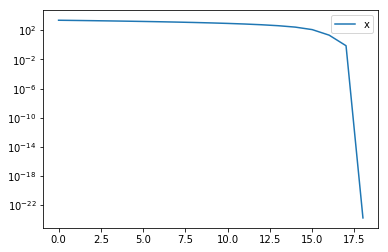

In [7]:
semilogy(log["func_val_x"], label="x")
legend()

## Real Grayscale Images 

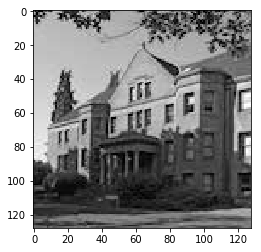

In [8]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
imshow(lewis)
gray()

In [9]:
m, n = lewis.shape
lewis = lewis.reshape(m*n)

In [10]:
def corrupt(data, p=0.1):
    noise = rand(len(data)) > p
    return data * noise

In [11]:
corrupted_lewis = corrupt(lewis, p=0.5)

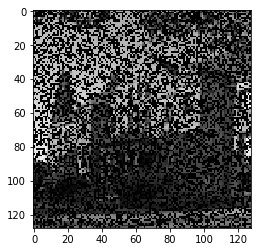

In [12]:
imshow(corrupted_lewis.reshape((m, n)))
gray()

In [13]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'constant'), deficit

#x, tail = pad_to_power_of_two(corrupted_lewis)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory1 = []
# D = zeros(k*len(x))
# D[:len(x)] = S[0]*S[1] + S[0]*S[2] + S[0]*S[3]
# D[len(x):2*len(x)] = S[1]*S[0] + S[1]*S[2] + S[1]*S[3]
# D[2*len(x):3*len(x)] = S[2]*S[0] + S[2]*S[1] + S[2]*S[3]
# D[3*len(x):] = S[3]*S[0] + S[3]*S[1] + S[3]*S[2]

In [14]:
def f(w, x, nu):
    return np.abs((np.abs(w) - b)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2

def prox_h(z, nu):
    y = ((abs(z) - b - nu).clip(0, None) - (-abs(z) + b - nu).clip(0, None) + b)
    return y*sign(z)

def pgd(f, prox, w0, nu = 1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    while (norm(x_prev-x) > tol) and iter_num < maxIter:
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox(Adot(x, k = k, S = S), nu)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, nu)
        log["func_val"].append(f_val)
        xs_trajectory1.append(x)
        iter_num += 1
    return w, log

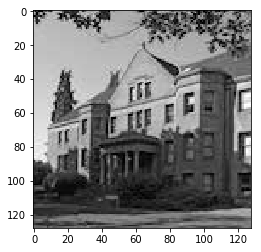

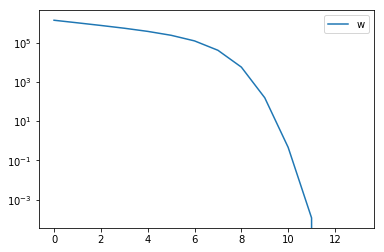

In [15]:
x0 = corrupted_lewis
w0 = Adot(x0)
nu = 20
f_min = f(w_star, lewis, nu)
w_pred, log = pgd(f, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

[]

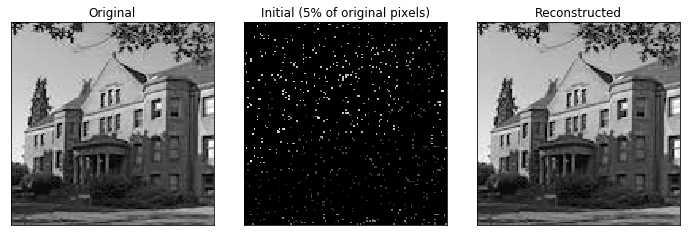

In [21]:
fig = figure(figsize=(12,4))
grid = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
orig = fig.add_subplot(grid[0, 0])
orig.imshow(lewis.reshape((m,n)))
orig.set_title("Original")
orig.set_xticks([])
orig.set_yticks([])
corrupted = fig.add_subplot(grid[0, 1])
corrupted.imshow(corrupted_lewis.reshape((m,n)))
corrupted.set_title("Initial (5% of original pixels)")
corrupted.set_xticks([])
corrupted.set_yticks([])
reconstructed = fig.add_subplot(grid[0, 2])
reconstructed.imshow(x_pred)
reconstructed.set_title("Reconstructed")
reconstructed.set_xticks([])
reconstructed.set_yticks([])

## Real Color Image

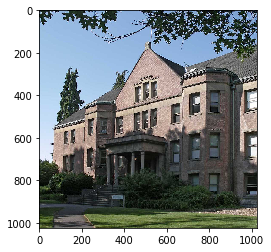

In [86]:
lewis = imread("lewis.jpeg")
imshow(lewis)
gray()

In [87]:
m, n, d = lewis.shape
lewis = lewis.reshape(m*n*d)

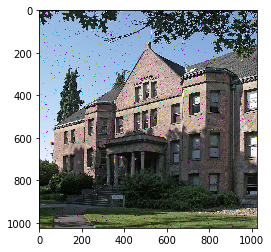

In [88]:
corrupted_lewis = corrupt(lewis, p=0.01)
imshow(corrupted_lewis.reshape((m, n, d)))

In [93]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'reflect'), deficit

corrupted_lewis_ext, tail = pad_to_power_of_two(corrupted_lewis)
lewis_ext, tail = pad_to_power_of_two(lewis)

seed(42)
k = 4
S = rand(k, len(corrupted_lewis_ext))
S = (S > 0.5)*2-1
b = np.abs(Adot(corrupted_lewis_ext, k = k, S = S))
w0 = Adot(corrupted_lewis_ext, k = k, S = S)
nu = 0.5
w_star = Adot(lewis_ext, k = k, S = S)
#f_min = f(w_star, lewis_ext, nu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


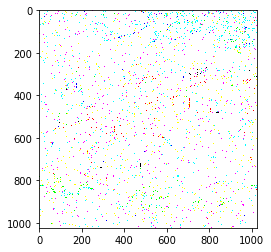

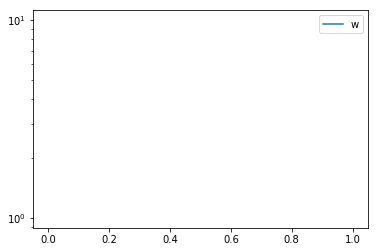

In [95]:
w_pred, log = pgd(f, grad_g, prox_h, w0 = w0, nu = nu, tol=1e-3)
x_pred = (ATdot(w_pred, k = k, S = S)[:-tail]).reshape((m, n, d))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

## Semi-quadratic loss

In [19]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.5)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory2 = []


def f(w, x, z, nu, lam):
    A = np.abs((np.abs(z) - b**2)).sum()
    B = 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2
    C = 1/(2*lam)*norm(w**2 - z)**2
    print(A, B, C, A+B+C)
    return np.abs((np.abs(z) - b**2)).sum() + 1/(2*nu)*norm(Adot(x, k = k, S = S) - w)**2 + 1/(2*lam)*norm(w**2 - z)**2

def prox_h(z, nu):
    y = ((abs(z) - b**2 - nu).clip(0, None) - (-abs(z) + b**2 - nu).clip(0, None) + b**2)
    return y*sign(z)

def prox_phi(z, x, nu, lam, y=None):
    w = zeros(len(z))
    y = Adot(x)
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
        
#         v = zi - lam/(2*nu)
#         u = lam*yi/(2*nu)
#         w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*sqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#         w[i] = w_alt
#        if i % 100000 == 0:
#            print(i)
        
#        plot(w[i], c(w[i]), 'o')
#        t_span = linspace(-2, 2, 100)
#        plot(t_span, c(t_span))
#        show()
#     v = z - lam/(2*nu)
#     u = lam*y/(2*nu)
#     w_alt = (2./3.)**(1./3.)*v/(sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.) + (sqrt(3)*csqrt(27*u**2 - 4*v**3) + 9*u)**(1./3.)/((2)**(1./3.)*3**(2./3.))
#     w = w_alt
    return w

def pgd2(w0, nu = 1, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    z = w0**2
    c = 0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    z_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(z, x, nu, lam)
        z = prox_h(w**2, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, z, nu, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory2.append(x)
        #print(f_val)
    return w, log

0
65215281.45751953 5.002654306810878e-25 53838551.24754883 119053832.70506836
1
25431030.02453237 1326891.0339402065 16870123.68131653 43628044.739789106
2
10426924.290849697 907403.1831848935 6422458.790814451 17756786.26484904
3
4430237.791612118 625086.215329795 2605065.698999494 7660389.705941407
4
1851752.9745522933 456755.8131099512 1140441.773193493 3448950.5608557374
5
751963.4065820036 349478.03179565177 486498.5403193824 1587939.9786970378
6
297990.25055994274 267623.8718250272 207931.3909739079 773545.5133588779
7
111771.66861526662 199382.70767118383 92693.69689007958 403848.07317653
8
46656.63244788727 128983.09343110846 34132.227699260184 209771.9535782559
9
21615.139400049615 54073.35409353755 14645.751399959467 90334.24489354662
10
11411.406729796137 8480.213505459424 5549.498041822477 25441.11827707804
11
6404.881084682558 536.4608229330987 2598.0861757136067 9539.428083329263
12
1402.092700006353 62.02309362190101 2511.6664868257258 3975.7822804539796
13
0.0 9.443440

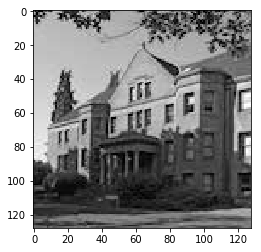

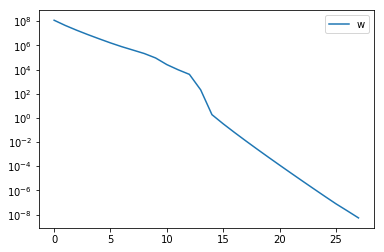

In [20]:
x0 = corrupted_lewis
w0 = Adot(x0)
nu = 20
lam = 5000

w_pred, log = pgd2(w0, lam = lam, nu = nu, maxIter=300, tol=1e-3)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

In [ ]:
x_pred =  xs_trajectory[50].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[100].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[200].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()

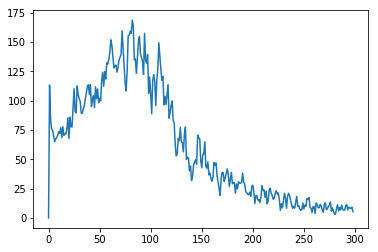

In [64]:
plot([norm(y - x) for x, y in zip(xs_trajectory[:-1], xs_trajectory[1:])])

## Quadratic loss

90% of pixels

In [16]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.5)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory3 = []


def f(w, x, lam):
    B = 1/(2*lam)*norm(Adot(x, k = k, S = S) - w)**2
    C = norm(w**2 - b**2)**2
    print(B, C, B+C)
    return B+C

def prox_phi(x, lam, y=None):
    y = Adot(x)
    w = zeros(len(y))
    z = b**2
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
    return w

def pgd3(w0, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:# and (norm(x_prev-x) > tol):
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(x, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory3.append(x)
        #print(f_val)
    return w, log

0
2406722.746822609 94696.91701339869 2501419.663836008
1
872067.7610952356 45435.004540590955 917502.7656358265
2
456548.20522883994 24285.55775348448 480833.7629823244
3
260750.9693875475 14131.47675132268 274882.44613887015
4
125003.85335339583 7197.441986931921 132201.29534032775
5
35955.586112721525 2537.672399732852 38493.25851245438
6
3451.0580620574874 483.2061944821146 3934.264256539602
7
62.22108692627836 41.007176101637064 103.22826302791543
8
0.20335473499770887 0.5212703529584202 0.724625087956129
9
0.0066604030574740295 0.01518150465605095 0.02184190771352498
10
0.00031657991343280936 0.000612550514016237 0.0009291304274490464
11
1.77829803927484e-05 2.9841815502717816e-05 4.7624795895466215e-05
12
1.0975243681644751e-06 1.6376857014543918e-06 2.735210069618867e-06
13
7.556649352294725e-08 9.922584900296589e-08 1.7479234252591314e-07
14
5.901153907107519e-09 4.628461838457126e-09 1.0529615745564646e-08
15
7.454424298576662e-11 2.0015042786943933e-11 9.455928577271055e-11


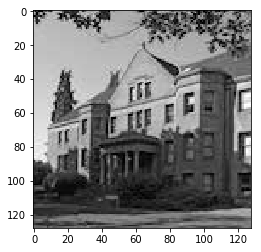

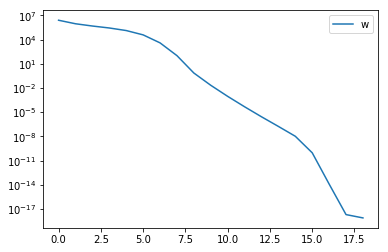

In [17]:
x0 = corrupted_lewis
w0 = Adot(x0)
lam = 20
w_pred, log = pgd3(w0, lam = lam, maxIter=2000, tol=1e-6)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

In [18]:
x_pred =  xs_trajectory[0].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[5].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[20].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()

NameError: name 'xs_trajectory' is not defined

50% of pixels

In [86]:
lewis = imread("lewis_grayscale_128.jpg")[:,:, 0]
m, n = lewis.shape
lewis = lewis.reshape(m*n)
corrupted_lewis = corrupt(lewis, p=0.05)

k = 4
seed(42)
S = rand(k, len(lewis))
S = (S > 0.5)*2-1

def Adot(x, k = k, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result/sqrt(k*m)

def ATdot(w, k=k, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/sqrt(k*m)


b = np.abs(Adot(lewis))
w_star = Adot(lewis)
xs_trajectory = []


def f(w, x, lam):
    B = 1/(2*lam)*norm(Adot(x, k = k, S = S) - w)**2
    C = norm(w**2 - b**2)**2
    print(B, C, B+C)
    return B+C

def prox_phi(x, lam, y=None):
    y = Adot(x)
    w = zeros(len(y))
    z = b**2
    for i, (zi, yi) in enumerate(zip(z, y)):
        c = np.poly1d([1/(2*lam),0,- (zi/lam - 1/(2*nu)),- yi/nu,(zi**2/(2*lam) + (yi)**2/(2*nu))])
        d = np.poly1d([1, 0, -(zi - lam/(2*nu)), -lam*yi/(2*nu)])
        d2 = np.poly1d([3, 0, -(zi - lam/(2*nu))])
        crit = d.r
        r_crit = crit[crit.imag==0].real
        test = d2(r_crit) 
        x_min = r_crit[test>0]
        w[i] = x_min[argmin(c(x_min))]
    return w

def pgd3(w0, lam=1, maxIter=2000, tol=1e-3):
    log = {"func_val" : [], "opt_cond" : []}
    w = w0
    iter_num = 0
    x = 0
    x_prev = 30
    w_prev = 30
    
    while iter_num < maxIter and (norm(x_prev-x) > tol) or iter_num < 3:# and (norm(x_prev-x) > tol):
        print(iter_num)
        x_prev = x
        x = ATdot(w, k = k, S = S)
        w = prox_phi(x, lam)
        log["opt_cond"].append(norm(x_prev - x))
        f_val = f(w, x, lam)
        log["func_val"].append(f_val)
        iter_num += 1
        xs_trajectory.append(x)
        #print(f_val)
    return w, log

In [88]:
x0 = corrupted_lewis
w0 = Adot(x0)
lam = 5000
w_pred, log = pgd3(w0, lam = lam, maxIter=2000, tol=1e-6)
x_pred =  ATdot(w_pred).reshape((m, n))
imshow(x_pred)
show()
semilogy(array(log["func_val"]), label="w")
legend()

0
505.52123769879734 9999512497.102617 9999513002.623856
1
96.47300073284242 2489329536.590675 2489329633.0636754
2


KeyboardInterrupt: 

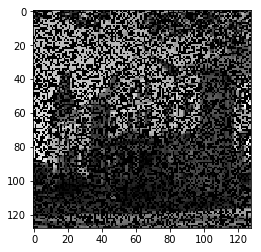

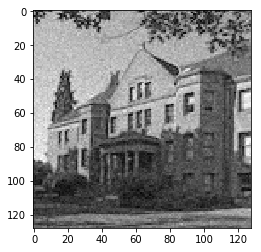

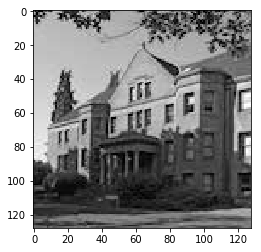

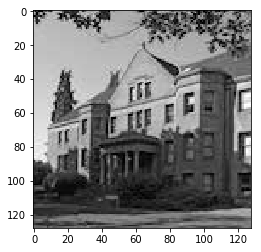

In [78]:
x_pred =  xs_trajectory[0].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[5].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[10].reshape((m, n))
imshow(x_pred)
show()
x_pred =  xs_trajectory[-1].reshape((m, n))
imshow(x_pred)
show()

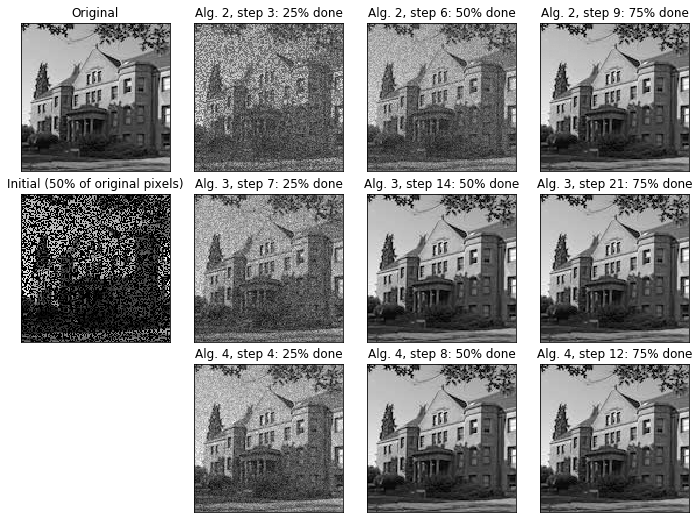

In [24]:
fig = figure(figsize=(12,9))
grid = plt.GridSpec(3, 4, wspace=0.15, hspace=0.15)
orig = fig.add_subplot(grid[0, 0])
orig.imshow(lewis.reshape((m,n)))
orig.set_title("Original")
orig.set_xticks([])
orig.set_yticks([])
corrupted = fig.add_subplot(grid[1, 0])
corrupted.imshow(corrupted_lewis.reshape((m,n)))
corrupted.set_title("Initial (50% of original pixels)")
corrupted.set_xticks([])
corrupted.set_yticks([])

t1 = int(len(xs_trajectory1)/4)
t2 = int(len(xs_trajectory2)/4)
t3 = int(len(xs_trajectory3)/4)

for j in range(1, 4):
    prog = fig.add_subplot(grid[0, j])
    prog.imshow(xs_trajectory1[j*t1].reshape((m,n)))
    prog.set_title("Alg. 2, step %d: %d%% done"%(j*t1, 25*j))
    prog.set_xticks([])
    prog.set_yticks([])
    prog = fig.add_subplot(grid[1, j])
    prog.imshow(xs_trajectory2[j*t2].reshape((m,n)))
    prog.set_title("Alg. 3, step %d: %d%% done"%(j*t2, 25*j))
    prog.set_xticks([])
    prog.set_yticks([])
    prog = fig.add_subplot(grid[2, j])
    prog.imshow(xs_trajectory3[j*t3].reshape((m,n)))
    prog.set_title("Alg. 4, step %d: %d%% done"%(j*t3, 25*j))
    prog.set_xticks([])
    prog.set_yticks([])
    
show()

## Dependency on the initial data

In [ ]:
range(5, 96, 5)

In [ ]:
for corr in range(5, 96, 5):
    